In [0]:
# mount drive if you downloaded the dependencies and dataset into your google drive
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
! sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (15.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 144429 files and directories cu

In [3]:
# restart runtime after installing git-lfs if you fail to clone
!git lfs clone https://github.com/liwei123/RTVASCAONEDetectron2.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'RTVASCAONEDetectron2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
Git LFS: (1 of 1 files) 313.82 MB / 313.82 MB


In [6]:
! mv RTVASCAONEDetectron2/* ./
! unzip detectron2uploads.zip

Archive:  detectron2uploads.zip
  inflating: metrics.json            
  inflating: val_traffic_dataset.csv  
  inflating: traffic_val_coco_format.json  
  inflating: final_sample_traffic_dataset.csv  
  inflating: instances_predictions.pth  
  inflating: coco_instances_results.json  
  inflating: model_final.pth         


In [7]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 23.4MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 7.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=0da1fe10376d7df098f6b8ed6311229fcb18ecb73e365c10116a7bf43ff8faaf
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [8]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 638kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200506-cp36-none-any.whl size=40569 sha256=451eec975b21de5de24fb84c0bcc2494cd82e42a7ff33b3cc5a27a542c99d30e
  Stored in directory: /root/.cache/pip/wheels/3f/db/ab/307827ba85b8cc1d288f096909499ecdbcac90db4edaa088fe
Successfully built fvcore


In [0]:
import os
import numpy as np
import pandas as pd
import json
import cv2
import random
import urllib
import requests
import ast
import matplotlib.pyplot as plt
from PIL import Image, ExifTags
from google.colab.patches import cv2_imshow

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

In [0]:
def load_mask(label, object_class, deg_rotation):
    label = ast.literal_eval(label)
    obj_list = label['objects']
    polygons = []    
    bboxes = []
    for i in range(len(obj_list)):
        if obj_list[i]['value'] == str(object_class):
            mask_uri = obj_list[i]['instanceURI']
            resp = requests.get(mask_uri, stream=True).raw
            try:
              mask_img = Image.open(resp)
            except:
              print("Request Error: ", mask_uri)
              return polygons, bboxes

            mask_img = mask_img.rotate(deg_rotation)
            mask_img = np.array(mask_img)
            mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
              c = np.asarray(c, dtype=np.float32)
              bbox = cv2.boundingRect(c)
              polygons.append(c)
              bboxes.append(bbox)
    return polygons, bboxes

In [0]:
def download_image(url, output_path):
    print("Downloading: ", url)
    urllib.request.urlretrieve(url, output_path)
    

In [0]:
def get_object_dicts(csv_dir, output_path):
    
    df = pd.read_csv(csv_dir, header=0)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    object_labels = ['trafficlight', 'car']
    dataset_dicts = []
    
    for index, row in df.iterrows():
        
        record = {}
        
        rotation = row['MaskClockwiseRotation']
        img_id = row['ID']
        img_url = row['Labeled Data']
        labels = row['Label']        
        img_name = img_id + '.jpg'
        
        img_location = os.path.join(output_path, img_name)
        
        if not os.path.isfile(img_location):
          download_image(img_url, img_location)
        
        print("Loading Image: ", img_location)

        img = detectron2.data.detection_utils.read_image(img_location)

        if img.size == 0:
          continue
        
        record["file_name"] = img_location
        record["image_id"] = img_id
        record["height"] = img.shape[0]
        record["width"] = img.shape[1]
        
        category_id = 0

        for lbl in object_labels:

          print("Loading mask for object: ", lbl)
          polygons, bboxes = load_mask(labels, lbl, 0)

          if not polygons or not bboxes:
            print("No segmentation or bounding box found... Skip")
            continue
          
          objs = []
          for i in range(len(polygons)):
              poly = polygons[i]
              poly = poly.flatten()
              poly = poly.tolist()

              if not poly or not (len(poly) % 2 == 0 and len(poly) >= 6):
                print("Segmentation Not Usable") 
                continue
              
              bbox = bboxes[i]
              
              obj = {
                  "bbox": bbox,
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "segmentation": [poly],
                  "category_id": category_id,
                  "iscrowd": 0
              }
              
              objs.append(obj)
          category_id += 1
            
        record["annotations"] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

In [0]:
train_csv = "final_sample_traffic_dataset.csv"
val_csv = "val_traffic_dataset.csv"
train = "train"
val = "val"

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.register("traffic_" + train, lambda train=train: get_object_dicts(train_csv, "trafficlights/" + train))
MetadataCatalog.get("traffic_" + train).set(thing_classes=["traffic light", "car"])

DatasetCatalog.register("traffic_" + val, lambda val=val: get_object_dicts(val_csv, "trafficlights/" + val))
MetadataCatalog.get("traffic_" + val).set(thing_classes=["traffic light", "car"])

traffic_metadata = MetadataCatalog.get("traffic_train")

In [0]:
train_dataset_dicts = get_object_dicts(train_csv, "trafficlights/" + train)

Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2Fe25af021-8a36-43a1-075a-38f453759c4e-traffic_18.jpg?Expires=1589121797930&KeyName=labelbox-assets-key-1&Signature=Nlp8mJETQBN3fcWBRIULhAY3xU8
Loading Image:  trafficlights/train/ck9ebsfj4syvj0740e9cftml6.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F27d7fae9-4110-4d20-6686-3fcaf42ac37f-traffic_50.jpg?Expires=1589121797937&KeyName=labelbox-assets-key-1&Signature=mGJCbzpE9FSM3uRAPXZnTcl1B1o
Loading Image:  trafficlights/train/ck9ebunsoici50976wjchlfy8.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Segmentation Not Usable
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F0890056b-ae18-5510-9a7c-45dad7ed0809-traffic_82.png?Expires=1589121797939&KeyName=labelbox-assets-key-1&Signature=wRIXm1t_WpoNaf73sFs89i8cNAI
Loading Image:  traff

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2Fa5f08628-f1df-6b1b-5432-25a9fa8cc09c-traffic_27.jpg?Expires=1589121797948&KeyName=labelbox-assets-key-1&Signature=uQkg5H3S6QFBOiSD0jFEoPHQypM
Loading Image:  trafficlights/train/ck9ecm7muiddl0861mb4cli7d.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F787fcfc0-b7db-94a1-f278-78a141d0449c-traffic_59.jpg?Expires=1589121797949&KeyName=labelbox-assets-key-1&Signature=ncMbYk1Yn0ujidXhxeKCvZO2w3U
Loading Image:  trafficlights/train/ck9ecn36pinb4097690yrhi23.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2Ff212327e-0f7b-f5b4-b762-491fb7c977f4-traffic_91.jpg?Expires=158912179795

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F5ef22909-7685-0a98-2d26-e2829f88ad12-traffic_30.jpg?Expires=1589121797951&KeyName=labelbox-assets-key-1&Signature=zwpLerGryZqLhmWrZ0d4EctZukA
Loading Image:  trafficlights/train/ck9ecpmbntc3007400h9ikiqe.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F78506387-a34d-e4ed-4eb6-20469eff276a-traffic_62.jpg?Expires=1589121797952&KeyName=labelbox-assets-key-1&Signature=VV8F3IB4Ecx0xEliv9S7wp0_Oa0
Loading Image:  trafficlights/train/ck9ecqoh1nnlt074261tlgokn.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F2d94d7ef-bb3a-d03a-7440-3bba9fd7d45a-traffic_94.jpg?Expires=158912179795

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F6415db32-72a6-0971-63e9-63b9bf041115-traffic_25.jpg?Expires=1589121797974&KeyName=labelbox-assets-key-1&Signature=0LP8BI73DD7kZilA_j4v-ISzbwY
Loading Image:  trafficlights/train/ck9edd52mqplp0889eydpodxj.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2F8adeebf1-6b5e-22dc-af6e-da786c4614fb-traffic_57.jpg?Expires=1589121797975&KeyName=labelbox-assets-key-1&Signature=Wr2hddtR0jBEv9QMWe6IhllptFI
Loading Image:  trafficlights/train/ck9edemx9im3908614pij8u51.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Downloading:  https://storage.labelbox.com/ck9ebfoxsich40a10xnrpj7cn%2Fa3c08d1e-c2dd-f4cf-fd0c-44fb7de31464-traffic_33.jpg?Expires=15891

In [0]:
train_dataset_dicts

[{'annotations': [{'bbox': (593, 108, 312, 871),
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'category_id': 0,
    'iscrowd': 0,
    'segmentation': [[786.0,
      108.0,
      785.0,
      109.0,
      762.0,
      109.0,
      761.0,
      110.0,
      748.0,
      110.0,
      747.0,
      111.0,
      746.0,
      111.0,
      745.0,
      112.0,
      744.0,
      112.0,
      743.0,
      113.0,
      741.0,
      113.0,
      740.0,
      114.0,
      739.0,
      114.0,
      738.0,
      115.0,
      736.0,
      115.0,
      735.0,
      116.0,
      734.0,
      116.0,
      733.0,
      117.0,
      732.0,
      117.0,
      731.0,
      118.0,
      729.0,
      118.0,
      728.0,
      119.0,
      727.0,
      119.0,
      726.0,
      120.0,
      724.0,
      120.0,
      723.0,
      121.0,
      722.0,
      121.0,
      721.0,
      122.0,
      720.0,
      122.0,
      719.0,
      123.0,
      717.0,
      123.0,
      716.0,
      124.0,
      715.0,
      124.

Image: /content/drive/My Drive/trafficlights/train/ck9ecm7muiddl0861mb4cli7d.jpg


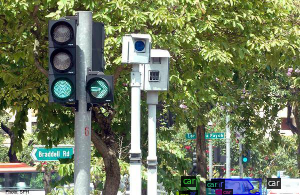

Image: /content/drive/My Drive/trafficlights/train/ck9ecpmbntc3007400h9ikiqe.jpg


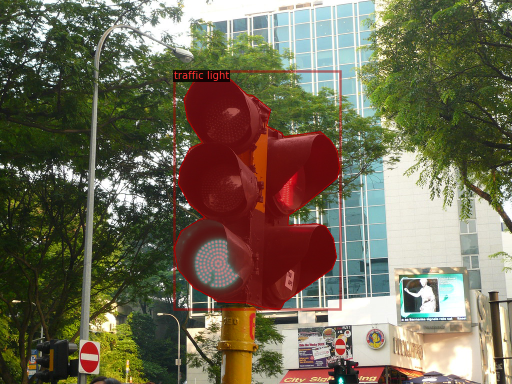

Image: /content/drive/My Drive/trafficlights/train/ck9edd52mqplp0889eydpodxj.jpg


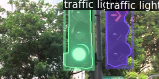

In [0]:
for d in random.sample(train_dataset_dicts, 3):
    print("Image:" , d["file_name"])
    img = detectron2.data.detection_utils.read_image(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=traffic_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [0]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("traffic_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/09 20:49:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecm7muiddl0861mb4cli7d.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecn36pinb4097690yrhi23.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecnl2zinfi0976zwsyrxbe.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecob0eqias0889g4n6axb7.jpg


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecpmbntc3007400h9ikiqe.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecqoh1nnlt074261tlgokn.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecrfdpioms09764efdt24p.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ecsuoaujmo075856sf2kou.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9ectrsq1t5i0799cr2yzl84.jpg
Loading mask for object:  trafficlight
Loading mask for object:  ca

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9edd52mqplp0889eydpodxj.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9edemx9im3908614pij8u51.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9edfwbhtjur07403g5vz4gs.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9edjf8mnwnf0742712v6urc.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/train/ck9edl6uoqs8f0889l0g72pl4.jpg
Loading mask for obje

model_final_f10217.pkl: 178MB [00:02, 69.0MB/s]                           


[05/09 20:52:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))


[05/09 20:52:36 d2.utils.events]:  eta: 0:02:45  iter: 19  total_loss: 2.843  loss_cls: 1.100  loss_box_reg: 0.924  loss_mask: 0.694  loss_rpn_cls: 0.030  loss_rpn_loc: 0.007  time: 0.4359  data_time: 0.2216  lr: 0.000005  max_mem: 2764M


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


[05/09 20:52:44 d2.utils.events]:  eta: 0:02:18  iter: 39  total_loss: 2.714  loss_cls: 1.107  loss_box_reg: 0.833  loss_mask: 0.687  loss_rpn_cls: 0.063  loss_rpn_loc: 0.015  time: 0.4127  data_time: 0.1271  lr: 0.000010  max_mem: 2764M


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


[05/09 20:52:51 d2.utils.events]:  eta: 0:02:13  iter: 59  total_loss: 2.496  loss_cls: 0.990  loss_box_reg: 0.698  loss_mask: 0.667  loss_rpn_cls: 0.064  loss_rpn_loc: 0.011  time: 0.4033  data_time: 0.1354  lr: 0.000015  max_mem: 2764M
[05/09 20:53:01 d2.utils.events]:  eta: 0:02:10  iter: 79  total_loss: 2.453  loss_cls: 0.847  loss_box_reg: 0.929  loss_mask: 0.639  loss_rpn_cls: 0.026  loss_rpn_loc: 0.010  time: 0.4188  data_time: 0.2149  lr: 0.000020  max_mem: 2764M
[05/09 20:53:09 d2.utils.events]:  eta: 0:02:04  iter: 99  total_loss: 2.235  loss_cls: 0.795  loss_box_reg: 0.754  loss_mask: 0.616  loss_rpn_cls: 0.062  loss_rpn_loc: 0.015  time: 0.4212  data_time: 0.1832  lr: 0.000025  max_mem: 2764M
[05/09 20:53:18 d2.utils.events]:  eta: 0:01:57  iter: 119  total_loss: 2.196  loss_cls: 0.689  loss_box_reg: 0.823  loss_mask: 0.565  loss_rpn_cls: 0.051  loss_rpn_loc: 0.011  time: 0.4266  data_time: 0.2206  lr: 0.000030  max_mem: 2764M
[05/09 20:53:26 d2.utils.events]:  eta: 0:01:50

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("traffic_val", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

val_loader = build_detection_test_loader(cfg, "traffic_val")
evaluator = COCOEvaluator("traffic_val", cfg, False, output_dir="./output/")
inference_on_dataset(trainer.model, val_loader, evaluator)

Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee003hj3o40976jl6tjumu.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee11qnjdze0a10zh8h8tp9.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee239mo3na07424iv16plu.jpg


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee325oqz370889dle1xvpl.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee4ekhuzrl07581chfxvc9.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee4qj3jf1q0a100u73xpbm.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee630sj60g09766n1qhnmu.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee6s8nj69i0976e03vo7mj.jpg
Loading mask for object:  traff

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eefpuoj0pn0861j1ejop9l.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eegqxxja4c0976uyc3tizk.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eehowgjjsb0a106mefo3wa.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eeihrlv4oo0758p2r0mpjb.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eemh7r2fhh0799t8meuly6.jpg
Loading mask for object:  traff

OrderedDict([('bbox',
              {'AP': 26.135374607753004,
               'AP-car': 14.281935065863232,
               'AP-traffic light': 37.988814149642764,
               'AP50': 39.323006958801436,
               'AP75': 31.807553743082188,
               'APl': 31.764158619749068,
               'APm': 45.78786644521072,
               'APs': 10.984269208831252}),
             ('segm',
              {'AP': 28.944963319593853,
               'AP-car': 16.648023512755653,
               'AP-traffic light': 41.24190312643206,
               'AP50': 39.85069960047178,
               'AP75': 31.22145877738612,
               'APl': 37.461460980820064,
               'APm': 47.00556614798679,
               'APs': 9.507831788395368})])

In [0]:
from detectron2.utils.visualizer import ColorMode
val_dataset_dicts = get_object_dicts(val_csv, "trafficlights/" + val)

Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee003hj3o40976jl6tjumu.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee11qnjdze0a10zh8h8tp9.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee239mo3na07424iv16plu.jpg


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 0, expected 1
  % (tag, len(values))


Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee325oqz370889dle1xvpl.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee4ekhuzrl07581chfxvc9.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee4qj3jf1q0a100u73xpbm.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee630sj60g09766n1qhnmu.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9ee6s8nj69i0976e03vo7mj.jpg
Loading mask for object:  traff

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 9, expected 1
  % (tag, len(values))


Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eefpuoj0pn0861j1ejop9l.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eegqxxja4c0976uyc3tizk.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eehowgjjsb0a106mefo3wa.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
No segmentation or bounding box found... Skip
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eeihrlv4oo0758p2r0mpjb.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
Loading Image:  /content/drive/My Drive/trafficlights/val/ck9eemh7r2fhh0799t8meuly6.jpg
Loading mask for object:  trafficlight
Loading mask for object:  car
L

In [0]:
for d in random.sample(val_dataset_dicts, 5):  
    print("Image:" , d["file_name"])
    im = detectron2.data.detection_utils.read_image(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=traffic_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [0]:
test_img = detectron2.data.detection_utils.read_image('trafficlights/trafficlightss.jpg')

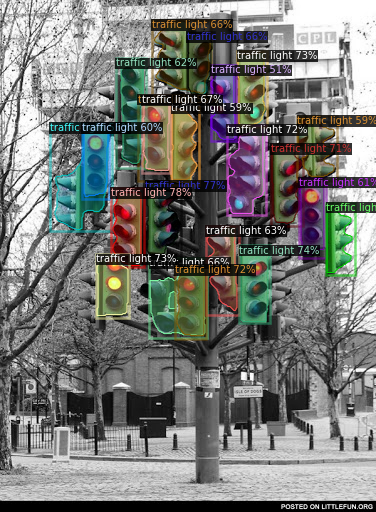

In [0]:
test_img_output = predictor(test_img)
v = Visualizer(test_img[:, :, ::-1],
                metadata=traffic_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(test_img_output["instances"].to("cpu"))
cv2_imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))